In [14]:
import base64
import markdown
import os
import re
import io
import shutil
import pandas as pd
import argparse
import numpy as np
from datetime import datetime
from datetime import date

from PIL import Image
from docx import Document
from os.path import basename

# 将doc转为mdFiles，并保存缩略图及base64，保存宽度1000图片结果

In [15]:
# 修改二进制流图像，300*
def resize_image(rb, size):
    imagePixmap = rb.size
    n_img = rb.resize(size, Image.ANTIALIAS)
    return n_img
        
# 修改二进制流图像，1000*
def resize_image_rb1000(rb):
    imagePixmap = rb.size
    width = imagePixmap[0]
    height = imagePixmap[1]
    scale = 1000/width
    n_img = rb.resize((int(width*scale), int(height*scale)), Image.ANTIALIAS)
    return n_img

# 保存图片
def save_image(img, save_path):
    img.save(save_path)
    return

# 图片转base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()
        base64_data = base64.b64encode(image_data)
        base64_string = base64_data.decode("utf-8")
        return base64_string
    
# 保存图片base64文本    
def save_base64(image_path, base64path):
    image_base64 = image_to_base64(image_path)
    text = '''data:image/{};base64,{}'''.format(image_path.split('.')[-1],image_base64)
    with open(base64path,'w') as f:
        f.write(text)
    
        
# 输入doc路径，完成所有doc markdown化
def docs2md(args, num):
    doc_path = "./{}/doc/".format(args.date)
    files = os.listdir(doc_path)
    files = [file for file in files if file == '{}.docx'.format(num)]
    if len(files) > 0:
        file = files[0]
        file_path = os.path.join(doc_path, file)
        outfile = os.path.join('./{}/mdFiles/'.format(args.date), file.split('.')[0]+'.txt')
        doc2markdown(args, num, file_path, outfile)
        print(file + ' done')
        # print('####################################')
    else:
        print('找不到{}日名为{}的文档！'.format(args.date,num))
        
# 将docx格式转化为markdown，包括图片，图片修改大小，粗体标识
def doc2markdown(args, num, docx, outfile):
    doc = Document(docx)

    # 读取每个段落的文本内容
    text = []
    save_text = []
    
    flag = 0
    pattern = re.compile('rId\d+')
    img_n = 1
    for paragraph in doc.paragraphs:
        run_line = ''
        for run in paragraph.runs:
            # print('run.text',run.text)
            if run.text != '':
                if run.bold:
                    line = '## <font color="#00e4ff">**{}**</font>'.format(run.text)
                    text.append(line)
                    continue
                    # print('cuti')
                else:
                    run_line += run.text
                save_text.append(run.text)
            
            else:
                # print(run.element.xml)
                try:
                    contentID = pattern.search(run.element.xml).group(0)
#                   print(contentID)
                except Exception as e:
                    print(e)
                    continue
                try:
                    contentType = doc.part.related_parts[contentID].content_type
                    # print(contentType)
                except KeyError as e:
                    print(e)
                    continue
                if not contentType.startswith('image'):
                    continue
                imgName = basename(doc.part.related_parts[contentID].partname)
                # print(imgName)
                imgData = doc.part.related_parts[contentID].blob
                img_t = contentType.split('/')[-1]
                
                image_stream = Image.open(io.BytesIO(imgData))
                
                # 保存处理成宽度1000px的图片
                new_imgData = resize_image_rb1000(image_stream)
                save_image1000_path = "./{}/pictures（留存参考）/{}.{}.png".format(args.date,num,img_n)
                save_image(new_imgData, save_image1000_path)
                # print("{}.{}.png".format(num,img_n),Image.open(save_image1000_path).size)
                
                # 保存第一个缩略图(300,200)
                if img_n == 1:
                    thub_imgData = resize_image(image_stream, (300,200))
                    save_thub_image_path = "./{}/thub_pic/{}.png".format(args.date,num)
                    save_image(thub_imgData, save_thub_image_path)
                    # print("thub {}.png saved! shape:".format(num),Image.open(save_thub_image_path).size)
                    
                    if args.thub_type == 'txt':
                        base64path = "./{}/thumbFiles/{}.txt".format(args.date, num)
                        save_base64(save_thub_image_path, base64path)
                        # print("thub {}.txt saved!".format(num))
                    else:
                        pic_path = "./{}/thumbFiles/{}.png".format(args.date, num)
                        shutil.copyfile(save_thub_image_path, pic_path)
                        # print("thub {}.png saved!".format(num))
                
                img_n += 1
                
                output_buffer = io.BytesIO()
                new_imgData.save(output_buffer, format=image_stream.format.lower())
                new_imgData = output_buffer.getvalue()
                
                img_base64 = base64.b64encode(new_imgData).decode('utf-8')
                text.append(f"![image](data:image/{img_t};base64,{img_base64})")                  
        text.append(run_line)
        # print('text',text)
    
    all_doctext = '\n\n'.join(text)
    with open(outfile, 'w', encoding='utf-8') as fout:
        fout.write(all_doctext)
    
    all_savetext = ''.join(save_text)
    save_txt_path = "./{}/text/{}.txt".format(args.date, num)
    with open(save_txt_path, 'w', encoding='utf-8') as fout:
        fout.write(all_savetext)
    return True


In [16]:
if __name__ == "__main__":
    from datetime import date
    import os
    os.chdir('./../news/')
    parser = argparse.ArgumentParser(description='doc')
    parser.add_argument('--date', type=str, default = '20240412', help='choose a date')
    parser.add_argument('--thub_type', type=str, default = 'txt', help='choose thumbnail type: txt, pic')
    args, unknown = parser.parse_known_args()
    
    # date = args.date
    date = ''.join(str(date.today()).split('-'))
    # date = '20240602'
    args.date = date
    if os.path.exists("./{}/text/".format(date)):
        shutil.rmtree("./{}/text/".format(date))
    if os.path.exists("./{}/mdFiles/".format(date)):
        shutil.rmtree("./{}/mdFiles/".format(date))
    if os.path.exists("./{}/pictures（留存参考）/".format(date)):
        shutil.rmtree("./{}/pictures（留存参考）/".format(date))
    if os.path.exists("./{}/thub_pic/".format(date)):
        shutil.rmtree("./{}/thub_pic/".format(date))
    if os.path.exists("./{}/thumbFiles/".format(date)):
        shutil.rmtree("./{}/thumbFiles/".format(date))
    
    os.makedirs("./{}/".format(date), exist_ok = True) 
    os.makedirs("./{}/doc/".format(date), exist_ok = True) 
    os.makedirs("./{}/text/".format(date), exist_ok = True) 
    os.makedirs("./{}/mdFiles/".format(date), exist_ok = True) 
    os.makedirs("./{}/pictures（留存参考）/".format(date), exist_ok = True) 
    os.makedirs("./{}/thub_pic/".format(date), exist_ok = True) 
    os.makedirs("./{}/thumbFiles/".format(date), exist_ok = True) 
    
    files = os.listdir("./{}/doc/".format(date))
    # print("./{}/doc/".format(date),files)
    files = [file for file in files if '.doc' in file]
    print('对下列文档进行处理：',files)
    
    for file in files:
        try:
            num = file.split('.')[0]
            docs2md(args, num)
        except Exception as e:
            print('===========================')
            print('{}.txt转写失败!!!失败原因:{}'.format(num,e))
            print('===========================')
        
    

对下列文档进行处理： []


# 测试markdown

In [17]:
from IPython.display import display, Markdown
from datetime import date
import os
os.chdir('./../news/')
# date = args.date
date = ''.join(str(date.today()).split('-'))
# date = '20240602'
num = 115  #51-55，111-115
kuaibao_num = 12   #6/12
# 定义markdown文本
def news():
    # for i in [1,2,3,4,5,6,51,52,53,111,112,113]:
    # for i in [114,115]:
    for i in [51,52,53,54,55,111,112,113,114,115]:
        print('-'*50 + '   ' + str(i) + '   ' + '-'*50)
        markdown_text = open("./{}/mdFiles/{}.txt".format(date,i), 'r', encoding='utf-8').read()

        # 显示markdown内容
        display(Markdown(markdown_text))

def kuaibao():
    for i in [6,12]:
        print('-'*100,i)
        markdown_text = open('./../kuaibao/{}/output/{}.txt'.format(date,i), 'r', encoding='utf-8').read()
        #战新6 集成电路     标题：科技/产品    投融资    政策/数据
        #未来12 未来信息    标题：前沿技术热点 重大事件资讯 重大技术创新 领军人物观点
        # 显示markdown内容
        display(Markdown(markdown_text))
news()
# kuaibao()

--------------------------------------------------   51   --------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: './20240605/mdFiles/51.txt'

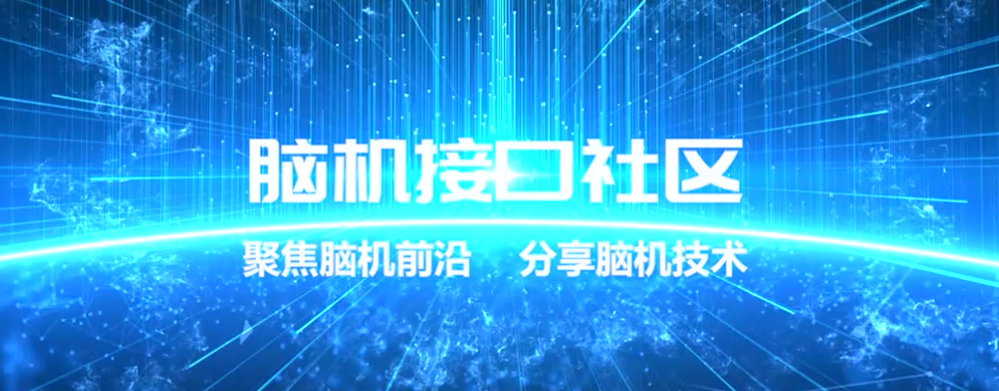



中国科学院深圳先进院-医工所智能材料中心博士后招聘启事

一、团队介绍

智能医用材料与器械研究中心（以下“智能材料中心”）成立于2021年8月，是中国科学院深圳先进技术研究院（简称“深圳先进院”）生物医学与健康工程研究所下属以智能医用材料为主要研究对象的研究单元。中心面向神经与心血管等疾病的重大需求，以医用材料关键科学问题为导向，发展构建促神经、血管等软组织再生修复与功能重建的多功能新概念材料和自适应生物器件，实现“材料智能”到“智能医用”的深度交叉融合，为生命健康领域对智能材料发展需求提供新的理论与技术支撑。中心近五年代表性成果发表在Science Advances、Matter、Advanced Materials、Advanced FunctionalMaterials、National Science Review等高水平学术期刊上，累计承担国家重点研发计划“变革性技术关键科学问题”重点专项、国家自然科学基金优秀青年基金、广东省创新团队、深圳市孔雀团队等各级竞争性项目。中心拥有国际一流的科研平台和自由开放的学术生态环境，诚邀海内外优秀人才加盟，共创辉煌！

二、研究方向

中心聚焦神经、血管等软组织的再生修复与功能重建研究。

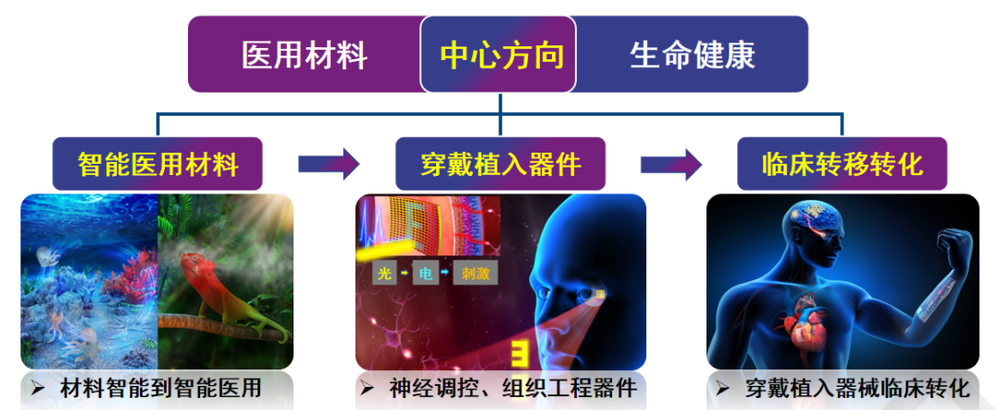

三、博士后职位具体要求

（一）应聘要求

1.已经或即将获得材料、化学、生物、医学或生物医学工程专业博士学位，有过仿生智能材料、刺激响应高分子、生物电子、神经接口器件、组织工程、传感器和软体驱动器或植入/穿戴式生物器件相关研究经历者优先；

2.具有浓厚的科研兴趣，以第一作者在国际知名期刊上发表过高水平SCI论文至少一篇；

3.踏实严谨，积极主动，乐观向上；

4.具有良好的沟通能力、团队协作能力及积极进取精神。

（二）福利待遇

1.提供在深圳地区及全国范围内有竞争力的薪酬，博士后年薪税前30~60万（含广东省及深圳市补贴）；

2.在站期间，符合条件的可竞争性申报国家“博新计划”（国家给予每人两年63万元的资助，其中40万元为博士后日常经费，20万元为博士后科学基金，3万元为国际交流经费）、博士后国际交流计划引进项目（40万/2年）。以上项目不与广东省及深圳市生活补贴兼得；

3.世界排名前200的境外高校毕业生，符合条件的可申请广东省“珠江人才”海外青年人才引进（博士后）项目共计100万元个人补贴；

4.出站后留深签约3年工作劳动合同，可申请深圳市博士后出站留（来）深科研资助30万，每年10万共计3年；

5.在站工作期间计入我院工龄，并可参加先进院职称评定，优秀者可推荐晋升为副研究员；

6.与正式员工同等享有年度考核奖金、年终奖金等；

7.根据个人需求，提供院内过渡房，单位协助申请人才安居房和人才租房补贴；

8.提供个人及配偶、子女深圳市户口落户、随迁的便利；依托附属中科硅谷幼儿园、中科深圳先院实验学校（小学、初中）等深圳市优质教育资源，提供子女就学的便利。

注：政府人才补贴具体随政策变化而调整。

四、应聘资料与联系方式

有意申请者，请将个人简历、着重介绍个人主要学术成就和受聘后工作设想的个人陈述材料以及重要代表性论文的全文合并为一个PDF文件，以邮件方式发送至xm.du@siat.ac.cn（杜老师），简历及邮件标题标明“应聘职位+本人姓名”。

本招聘信息长期有效。

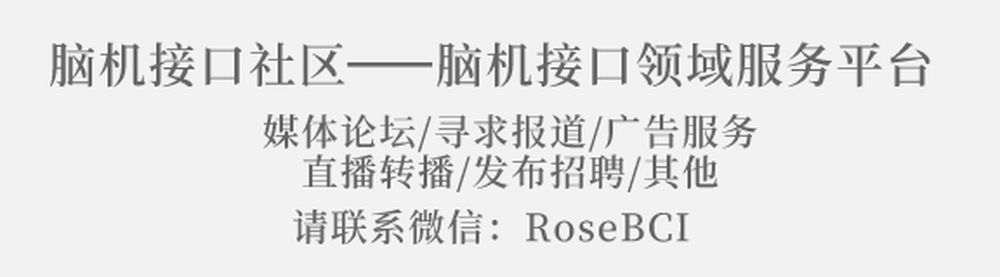

In [ ]:
file = r'E:\战新\gitcode\news\recommend\20240528\人工智能\mdFiles\3.txt'
markdown_text = open(file, 'r', encoding='utf-8').read()

# 显示markdown内容
display(Markdown(markdown_text))
